# Melonama Detection

## Problem Statement
### Melonama Cancer Detection
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

#### Project needs to follow the below requirements:
- Project pipeline as described
- Rescale the images to normalize pixel values between (0,1)
- Choose an appropriate optimiser and loss function for model training
- Train the model for ~20 epochs
- Choose an appropriate data augmentation strategy 
- Class distribution: Examine the current class distribution in the training dataset 
  - Which class has the least number of samples?
  - Which classes dominate the data in terms of the proportionate number of samples?
- Handling class imbalances: Rectify class imbalances present in the training dataset with Augmentor library.

#### NOTE:
You don't have to use any pre-trained model using Transfer learning. All the model building processes should be based on a custom model.

## Importing all the important libraries

In [1]:
#Import the required libraries needed for assignment
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

### Importing Skin Cancer Data

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null

replace Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


## Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

## Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
keras. __version__

'2.8.0'

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# Listing out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Visualize the data
#### Visualizing one instance of all the nine classes present in the dataset

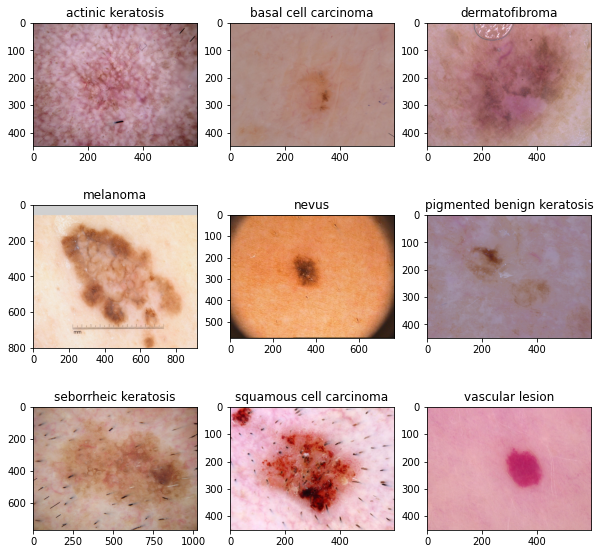

In [11]:
#Visualizing the image of each class
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Creating the model M1:
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
###CNN Model
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)))   #Rescaling Layer

#First Convolutional layer
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape = (img_height, img_width, 32)))
model.add(MaxPool2D(pool_size=(2,2)))

#Second Convolutional Layer
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

#Third Convolutional Layer
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(Flatten())

#Dense Layer
model.add(Dense(128,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Compile the model M1
Choose an appropirate optimiser and loss function for model training 

In [14]:
### choosing an appropirate optimiser and loss function
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Train the model M1

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 17s 85ms/step - loss: 2.0685 - accuracy: 0.2104 - val_loss: 1.9114 - val_accuracy: 0.2975
Epoch 2/20
56/56 [==============================] - 2s 38ms/step - loss: 1.8056 - accuracy: 0.3387 - val_loss: 1.6900 - val_accuracy: 0.3736
Epoch 3/20
56/56 [==============================] - 2s 38ms/step - loss: 1.6322 - accuracy: 0.4124 - val_loss: 1.5430 - val_accuracy: 0.4810
Epoch 4/20
56/56 [==============================] - 2s 38ms/step - loss: 1.4101 - accuracy: 0.5184 - val_loss: 1.6193 - val_accuracy: 0.4810
Epoch 5/20
56/56 [==============================] - 2s 38ms/step - loss: 1.3356 - accuracy: 0.5240 - val_loss: 1.4112 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 2s 38ms/step - loss: 1.2574 - accuracy: 0.5541 - val_loss: 1.4379 - val_accuracy: 0.5056
Epoch 7/20
56/56 [==============================] - 2s 38ms/step - loss: 1.1744 - accuracy: 0.5809 - val_loss: 1.5000 - val_accuracy: 0.5257
Epoch 8/20
5

### Visualizing training results M1

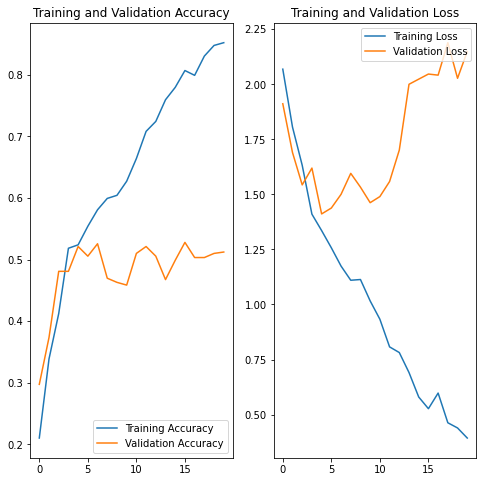

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings based on Model M1:
- Model M1 is overfitting in the above graph for Accuracy and Loss
- Accuracy is less here.
- We could see changes from the epoch 10-20
- M1 model looks like overfitting with less accuracy

In [18]:
# choosing an appropriate data augumentation strategy.
data_augument = keras.Sequential([
                             keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             keras.layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             keras.layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
                             ])

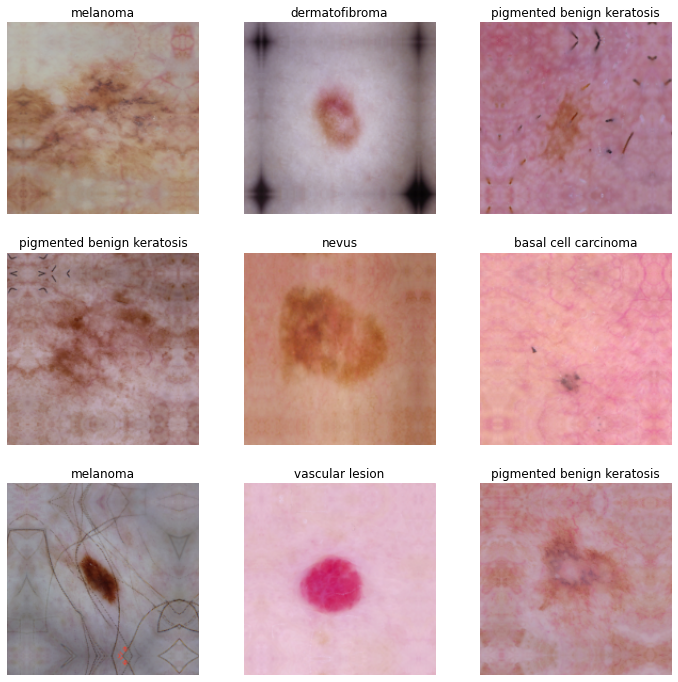

In [19]:
# Visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Model M2:
### Create the model, compile and train the model


In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
###CNN Model
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)))   #Rescaling Layer

#First Convolutional layer
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape = (img_height, img_width, 32)))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

#Second Convolutional Layer
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

#Third Convolutional Layer
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(Flatten())

#Dense Layer
model.add(Dense(128,activation='relu'))

#Dropout Layer
model.add(Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 176, 176, 32)      2432      
                                                                 
 conv2d_4 (Conv2D)           (None, 172, 172, 32)      25632     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 86, 86, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 84, 84, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                                                  

### Compiling the model M2

In [21]:
## Your code goes here
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

### Training the model M2

In [22]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 89ms/step - loss: 2.0986 - accuracy: 0.2070 - val_loss: 1.9829 - val_accuracy: 0.2215
Epoch 2/20
56/56 [==============================] - 4s 78ms/step - loss: 1.9433 - accuracy: 0.2489 - val_loss: 1.8405 - val_accuracy: 0.3490
Epoch 3/20
56/56 [==============================] - 4s 78ms/step - loss: 1.8534 - accuracy: 0.3203 - val_loss: 1.7311 - val_accuracy: 0.3758
Epoch 4/20
56/56 [==============================] - 4s 78ms/step - loss: 1.7515 - accuracy: 0.3538 - val_loss: 1.6721 - val_accuracy: 0.3736
Epoch 5/20
56/56 [==============================] - 4s 79ms/step - loss: 1.6872 - accuracy: 0.3890 - val_loss: 1.5391 - val_accuracy: 0.4430
Epoch 6/20
56/56 [==============================] - 4s 79ms/step - loss: 1.6216 - accuracy: 0.4191 - val_loss: 1.7049 - val_accuracy: 0.3714
Epoch 7/20
56/56 [==============================] - 4s 79ms/step - loss: 1.6724 - accuracy: 0.3951 - val_loss: 1.6101 - val_accuracy: 0.4452
Epoch 8/20
56

### Visualizing the results M2

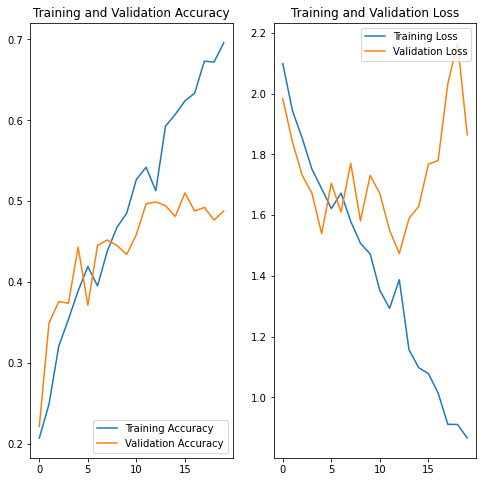

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings:
#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
- There is no improvement in accuracy.
- The overfitting problem has been solved due to data augmentation.
- We can tune the hyper-parameters or check whether solving class imbalance improves the model.

####  Finding the data distribution of classes in the training dataset.

In [24]:
## Your code goes here.
path_listing=[]
class_listing=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_listing.append(str(j))
        class_listing.append(i)
df_orig = dict(zip(path_listing, class_listing))
original_df = pd.DataFrame(list(df_orig.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/Skin cancer ISIC The International Sk...,actinic keratosis
1,/content/Skin cancer ISIC The International Sk...,actinic keratosis
2,/content/Skin cancer ISIC The International Sk...,actinic keratosis
3,/content/Skin cancer ISIC The International Sk...,actinic keratosis
4,/content/Skin cancer ISIC The International Sk...,actinic keratosis
...,...,...
2234,/content/Skin cancer ISIC The International Sk...,vascular lesion
2235,/content/Skin cancer ISIC The International Sk...,vascular lesion
2236,/content/Skin cancer ISIC The International Sk...,vascular lesion
2237,/content/Skin cancer ISIC The International Sk...,vascular lesion


<BarContainer object of 9 artists>

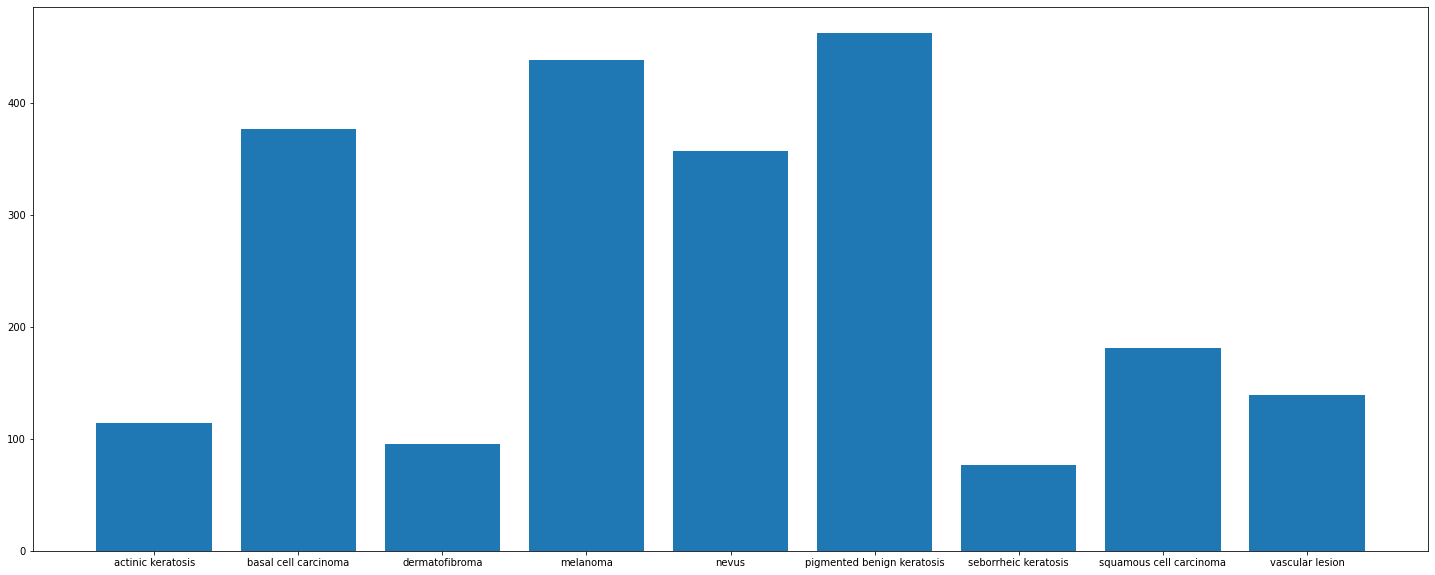

In [25]:
#Visualize the Number of image in each class.
import seaborn as sns
class_count=[]
for i in class_names:
    class_count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,class_count)

In [26]:
print(class_names)
print(class_count)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
[114, 376, 95, 438, 357, 462, 77, 181, 139]


####  Write your findings here: 
####  Which class has the least number of samples?
- seborrheic keratosis has least number of samples. 


####  Which classes dominate the data in terms proportionate number of samples?
- melanoma and pigmented benign keratosis classes dominate the data in terms of proportionate number of samples. Another set of classes are basal cell carcinoma and nevus classes.

##  Rectifying the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset+i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDF11E9AFD0>: 100%|██████████| 500/500 [00:17<00:00, 29.16 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDF11AD8050>: 100%|██████████| 500/500 [00:19<00:00, 26.16 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDF11B78850>: 100%|██████████| 500/500 [00:20<00:00, 24.60 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FDF11B64790>: 100%|██████████| 500/500 [01:39<00:00,  5.01 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FDF11B4EA90>: 100%|██████████| 500/500 [01:16<00:00,  6.56 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDFA318D8D0>: 100%|██████████| 500/500 [00:17<00:00, 29.30 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FDF264A4510>: 100%|██████████| 500/500 [00:41<00:00, 12.09 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDF11EF10D0>: 100%|██████████| 500/500 [00:16<00:00, 30.19 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDF11B69790>: 100%|██████████| 500/500 [00:18<00:00, 26.93 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [35]:
import glob
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010394.jpg_c43a6a09-0629-401e-b748-008d6654b663.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001141.jpg_8c236a8e-f709-4cf9-a7b2-fa890029ed66.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010426.jpg_c594f452-97a3-441d-a8d6-b6d2a2e82463.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011135.jpg_0720005d-3a65-4cc1-b495-bafb27e98144.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010251.jpg_682ee410-59c6-4698-994c-b5ab51070fc5.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000441.jpg_f29f3

In [36]:
import os
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [37]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [38]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [39]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## Train the model on the data created using Augumentor M3

In [40]:
batch_size = 32
img_height = 180
img_width = 180

###  Create a training dataset M3

In [41]:
data_dir_train="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Create a validation dataset M3

In [42]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


###  Create model (make sure to include normalization) M3:

In [43]:
## your code goes here
###CNN Model
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)))   #Rescaling Layer

#First Convolutional layer
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape = (img_height, img_width, 32)))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

#Second Convolutional Layer
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

#Third Convolutional Layer
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(Flatten())

#Dense Layer
model.add(Dense(128,activation='relu'))

#Dropout Layer
model.add(Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 176, 176, 32)      2432      
                                                                 
 conv2d_8 (Conv2D)           (None, 172, 172, 32)      25632     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 86, 86, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 84, 84, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                                                  

### Compile your model (Choose optimizer and loss function appropriately) M3

In [44]:
## your code goes here
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [45]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 176, 176, 32)      2432      
                                                                 
 conv2d_8 (Conv2D)           (None, 172, 172, 32)      25632     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 86, 86, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 84, 84, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                                                  

### Train your model M3

In [46]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 28s 158ms/step - loss: 2.0056 - accuracy: 0.2372 - val_loss: 1.7619 - val_accuracy: 0.3356
Epoch 2/30
169/169 [==============================] - 26s 150ms/step - loss: 1.7315 - accuracy: 0.3329 - val_loss: 1.5213 - val_accuracy: 0.4165
Epoch 3/30
169/169 [==============================] - 26s 149ms/step - loss: 1.5486 - accuracy: 0.3947 - val_loss: 1.4601 - val_accuracy: 0.4284
Epoch 4/30
169/169 [==============================] - 27s 157ms/step - loss: 1.4403 - accuracy: 0.4442 - val_loss: 1.3781 - val_accuracy: 0.4581
Epoch 5/30
169/169 [==============================] - 26s 150ms/step - loss: 1.3211 - accuracy: 0.4937 - val_loss: 1.3883 - val_accuracy: 0.4722
Epoch 6/30
169/169 [==============================] - 26s 149ms/step - loss: 1.2446 - accuracy: 0.5226 - val_loss: 1.2460 - val_accuracy: 0.5353
Epoch 7/30
169/169 [==============================] - 26s 149ms/step - loss: 1.1119 - accuracy: 0.5875 - val_loss: 1.2244 - val_ac

### Visualize the model results M3

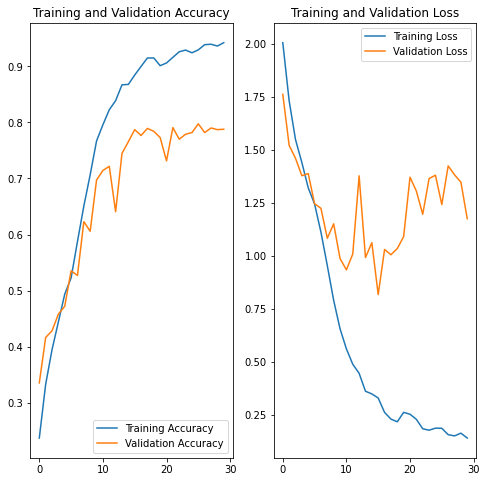

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

Overfitting has reduced little bit. But accuracy has improved much. Yes
class imbalance has helped.
